**Setup and Dataset Preprocessing**

Imports

In [20]:
from google.colab import drive, files
import copy, os, shutil, time
from zipfile import ZipFile
import torch
from torch import nn, cuda, device, optim
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2, glob

Dataset directory name and it's intended path

In [21]:
dir_name = "indian_birds_dataset"
dataset_path = os.path.join("/content", dir_name)

Mount Google Drive locally, to access dataset - `archive.zip`.

In [22]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracts the dataset into `"/content"`. **NOTE**: Replace the value `dataset_path` with the path to `archive.zip` in Google Drive (e.g. `"/content/drive/MyDrive/.../archive.zip"`).

In [23]:
dataset_zip_path = "/content/drive/MyDrive/CS614/archive.zip"

with ZipFile(dataset_zip_path, "r") as zip:
  zip.extractall("/content")

Moves the dataset's root directory from `"training_dataset"` to `"indian_birds_dataset"`

In [24]:
shutil.move("/content/training_set", dataset_path)

'/content/indian_birds_dataset/training_set'

Delete accidental directory


In [25]:
def delete_dir(path):
  if os.path.isdir(path):
    print(f"Deleting {path}")
    shutil.rmtree(path, ignore_errors=True)

In [26]:
delete_dir(os.path.join(dataset_path, "training_set"))

Deleting /content/indian_birds_dataset/training_set


Static dataset and model variables

In [27]:
input_size = 299
num_classes = 25
batch_size_train = 20
batch_size_vt = 20
num_epochs = 1 
num_workers = 2
learning_rate = 0.0001
momentum = 0.9

dataset_split = {"train" : 0.8, "valid" : 0.1, "test": 0.1}

Model

In [28]:
model = models.resnet34(weights="DEFAULT")
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

Prepares the dataset.

Wrapper class

Because `random_split` doesn't actually split the dataset, but just keeps the indices of the subsets. This class allows me to apply different transformations to training vs the testing and validation subsets. 

In [11]:
class WrapperDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

Dataset Preprocessing

In [13]:
full_dataset = datasets.ImageFolder(dataset_path)

class_to_idx = full_dataset.class_to_idx

generator = torch.Generator().manual_seed(42)
_train, _valid, _test = random_split(full_dataset, [x for x in dataset_split.values()], generator=generator)

num_total_samples = len(_train.dataset)
num_samples = {}
for i in range(len(dataset_split)):
  ds = list(dataset_split.keys())[i]
  num_samples[ds] = int(dataset_split[ds] * num_total_samples)

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train = WrapperDataset(_train, transform=train_transform)
test = WrapperDataset(_test, transform=valid_test_transform)
valid = WrapperDataset(_valid, transform=valid_test_transform)

train_loader = DataLoader(train , batch_size=batch_size_train, num_workers=num_workers,  shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size_vt, num_workers=num_workers)
test_loader = DataLoader(test, batch_size=batch_size_vt, num_workers=num_workers)

List of classes and mapping from index to class

In [29]:
classes = list(class_to_idx.keys())

idx_to_class = {}
for clas, index in class_to_idx.items():
  idx_to_class[index] = clas
print(idx_to_class)

{0: 'Asian Green Bee-Eater', 1: 'Brown-Headed Barbet', 2: 'Cattle Egret', 3: 'Common Kingfisher', 4: 'Common Myna', 5: 'Common Rosefinch', 6: 'Common Tailorbird', 7: 'Coppersmith Barbet', 8: 'Forest Wagtail', 9: 'Gray Wagtail', 10: 'Hoopoe', 11: 'House Crow', 12: 'Indian Grey Hornbill', 13: 'Indian Peacock', 14: 'Indian Pitta', 15: 'Indian Roller', 16: 'Jungle Babbler', 17: 'Northern Lapwing', 18: 'Red-Wattled Lapwing', 19: 'Ruddy Shelduck', 20: 'Rufous Treepie', 21: 'Sarus Crane', 22: 'White Wagtail', 23: 'White-Breasted Kingfisher', 24: 'White-Breasted Waterhen'}


GPU/CPU

In [30]:
devic = device("cuda:0" if cuda.is_available() else "cpu")
print("device:", devic)

device: cpu


In [ ]:
model = model.to(devic)

---

**Testing**

Load trained model, **NOTE**: Change the name of `model_drive_path` to the path to model weights file, `model`, in 

In [32]:
model_drive_path = "drive/MyDrive/my_resnet_model"

model_dict = torch.load(model_drive_path, map_location=torch.device(devic))
print(model_dict.keys())

model.load_state_dict(model_dict)

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.bn1.num_batches_tracked', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', '

<All keys matched successfully>

`print_eval_update()` is used to print the number of samples seen and accuracy in `evaluate()`.

In [39]:
def print_eval_update(num_correct, current_samples, total_num_samples):
  print("num_correct:", num_correct)
  print("current_num_samples:", current_samples)
  print("current_accuracy: {:.4f}".format(num_correct/current_samples))
  print("total_accuracy: {:.4f}".format(num_correct/total_num_samples))
  print()

`evaluate()` evaluates the model's performance on the validation and testing datasets. It also prints out a confusion matrix of the results

You can comment out the call to `print_eval_update()` if you want to reduce the output

In [40]:
def evaluate(model, device, data_loader, subset_name, num_samples_subset, classes):

  model.eval()

  num_classes = len(classes)
  correct = 0
  samples = 0
  all_preds = []
  all_actual = []

  for inputs, labels in data_loader:
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    correct += torch.sum(preds == labels.data)
    
    _preds = preds.data.cpu().numpy()
    _labels = labels.data.cpu().numpy()
    all_preds.extend(_preds)
    all_actual.extend(_labels)

    samples += len(preds)

    if samples % 100 == 0:
      print_eval_update(correct.item(), samples, num_samples_subset)
  
  accuracy = correct.item()/num_samples_subset
  print("\naccuracy", accuracy)

  conf_matrix = confusion_matrix(all_actual, all_preds)
  cmp = ConfusionMatrixDisplay(conf_matrix)
  fig, ax = plt.subplots(figsize=(10,10))
  cmp.plot(ax=ax)
  plt.savefig(f'/content/{subset_name}_confusion_matrix.png')
  


Validation Dataset Evaluation

valid total samples: 2262 

num_correct: 100
current_num_samples: 100
current_accuracy: 1.0000
total_accuracy: 0.0442

num_correct: 198
current_num_samples: 200
current_accuracy: 0.9900
total_accuracy: 0.0875

num_correct: 295
current_num_samples: 300
current_accuracy: 0.9833
total_accuracy: 0.1304

num_correct: 393
current_num_samples: 400
current_accuracy: 0.9825
total_accuracy: 0.1737

num_correct: 492
current_num_samples: 500
current_accuracy: 0.9840
total_accuracy: 0.2175

num_correct: 587
current_num_samples: 600
current_accuracy: 0.9783
total_accuracy: 0.2595

num_correct: 686
current_num_samples: 700
current_accuracy: 0.9800
total_accuracy: 0.3033

num_correct: 783
current_num_samples: 800
current_accuracy: 0.9788
total_accuracy: 0.3462

num_correct: 880
current_num_samples: 900
current_accuracy: 0.9778
total_accuracy: 0.3890

num_correct: 978
current_num_samples: 1000
current_accuracy: 0.9780
total_accuracy: 0.4324

num_correct: 1075
current_num_samples: 1100
current_accuracy:

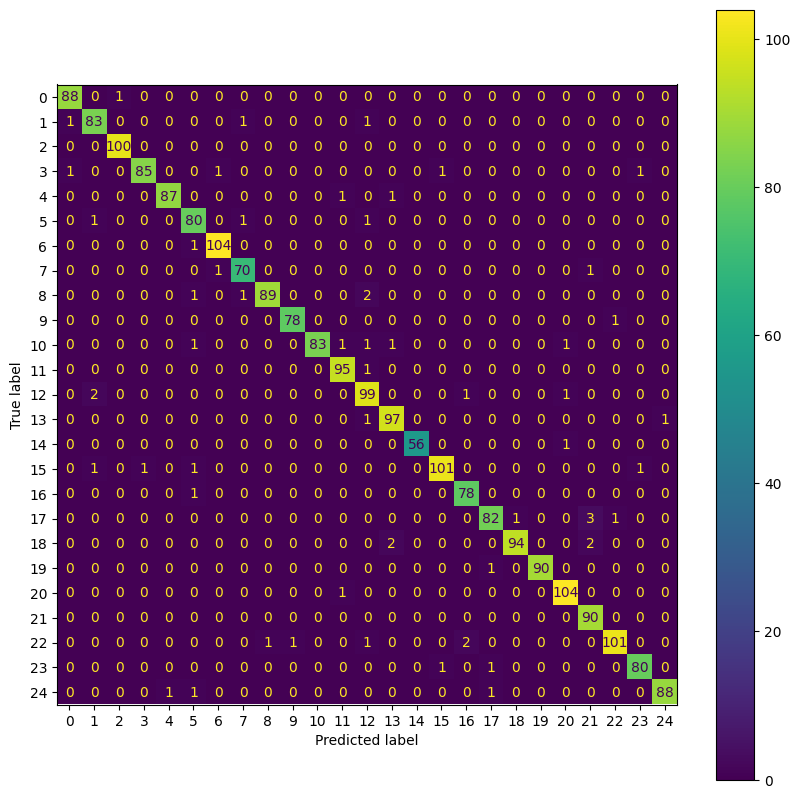

In [42]:
print("valid total samples:", num_samples["valid"], "\n")
evaluate(model, device, valid_loader, "valid", num_samples["valid"], classes)

Test Dataset Evaluation

In [43]:
print("test total samples:", num_samples["test"], "\n")
evaluate(model, device, test_loader, "test", num_samples["test"], classes)

test total samples: 2262 

num_correct: 97
current_num_samples: 100
current_accuracy: 0.9700
total_accuracy: 0.0429

num_correct: 196
current_num_samples: 200
current_accuracy: 0.9800
total_accuracy: 0.0866

num_correct: 292
current_num_samples: 300
current_accuracy: 0.9733
total_accuracy: 0.1291



KeyboardInterrupt: ignored

Test Examples

`generate_sample_subset()` creates a subset of the `indian_birds_dataset`, specifically a directory in the same structure as `indian_birds_dataset`, given a list of images

In [44]:
def generate_sample_subset(filepaths, subset_dataset_path):
  import glob
  
  if os.path.isdir(subset_dataset_path) == False:
    os.makedirs(subset_dataset_path)

  dirs = glob.glob(dataset_path + "/*")
  new_images = []
  for dir in dirs:
    dir_basename = os.path.basename(dir)
    dir_path = os.path.join(subset_dataset_path, os.path.basename(dir))
    if os.path.isdir(dir_path) == False:
      os.makedirs(dir_path)
  
  for file in filepaths:
    og_filepath = os.path.join(dataset_path, file)
    new_filepath = os.path.join(subset_dataset_path, file)
    if os.path.isfile(og_filepath) == True and os.path.isfile(new_filepath) == False:
      shutil.copyfile(og_filepath, new_filepath)
      if os.path.isfile(new_filepath) == False:
        print(f"Failed to copy over {og_filepath}.")
      else:
        print(new_filepath)
      new_images.append(new_filepath)
  print("Done creating subset of dataset.")
  return new_images






Creates the sample dataset `indian_birds_dataset_subset`

In [45]:
subset_dataset_path = "/content/indian_birds_dataset_subset"

#Some test examples pulled from the Test Dataset
incorrect = ["Indian Peacock/ML347405821.jpg", 
             "House Crow/ML503964861.jpg", 
             "Indian Grey Hornbill/ML77061781.jpg", 
             "Brown-Headed Barbet/ML290838891.jpg", 
             "Gray Wagtail/ML313524561.jpg", 
             "Red-Wattled Lapwing/ML98206961.jpg", 
             "Ruddy Shelduck/ML396122561.jpg", 
             "House Crow/ML110722671.jpg", 
             "Indian Roller/ML183145991.jpg"]

correct = [ "Indian Grey Hornbill/ML106408871.jpg", 
           "Indian Peacock/ML359756441.jpg", 
           "Common Myna/ML268701161.jpg", 
           "Common Rosefinch/ML72047811.jpg", 
           "White-Breasted Waterhen/ML227087131.jpg", 
           "White Wagtail/ML350263231.jpg", 
           "House Crow/ML166883151.jpg", 
           "Northern Lapwing/ML414357021.jpg", 
           "Indian Pitta/ML528943911.jpg", 
           "Asian Green Bee-Eater/ML196703651.jpg",
           "Common Kingfisher/ML204444751.jpg",
           "Rufous Treepie/ML85279711.jpg",
           "Sarus Crane/ML136277331.jpg",
           "White Wagtail/ML152781481.jpg",
           "Coppersmith Barbet/ML79408821.jpg",
           "Hoopoe/ML205105201.jpg",
           "Cattle Egret/ML388884741.jpg",
           "White-Breasted Kingfisher/ML205857601.jpg",
           "Forest Wagtail/ML397067501.jpg",
           "Common Tailorbird/ML166735161.jpg",
           "Jungle Babbler/ML32855221.jpg"]

delete_dir(os.path.join(subset_dataset_path, "indian_birds_dataset"))

subset_image_paths = generate_sample_subset(incorrect + correct, subset_dataset_path)

/content/indian_birds_dataset_subset/Indian Peacock/ML347405821.jpg
/content/indian_birds_dataset_subset/House Crow/ML503964861.jpg
/content/indian_birds_dataset_subset/Indian Grey Hornbill/ML77061781.jpg
/content/indian_birds_dataset_subset/Brown-Headed Barbet/ML290838891.jpg
/content/indian_birds_dataset_subset/Gray Wagtail/ML313524561.jpg
/content/indian_birds_dataset_subset/Red-Wattled Lapwing/ML98206961.jpg
/content/indian_birds_dataset_subset/Ruddy Shelduck/ML396122561.jpg
/content/indian_birds_dataset_subset/House Crow/ML110722671.jpg
/content/indian_birds_dataset_subset/Indian Roller/ML183145991.jpg
/content/indian_birds_dataset_subset/Indian Grey Hornbill/ML106408871.jpg
/content/indian_birds_dataset_subset/Indian Peacock/ML359756441.jpg
/content/indian_birds_dataset_subset/Common Myna/ML268701161.jpg
/content/indian_birds_dataset_subset/Common Rosefinch/ML72047811.jpg
/content/indian_birds_dataset_subset/White-Breasted Waterhen/ML227087131.jpg
/content/indian_birds_dataset_su

Prepares the sample dataset

In [46]:
subset_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

subset_dataset = datasets.ImageFolder(subset_dataset_path, transform=subset_transform)

subset_loader = DataLoader(subset_dataset, batch_size=1, num_workers=num_workers)

`evaluate_subset()` evaluates the sample dataset using the model and prints out in input image with predicted and actual class

In [47]:
def evaluate_subset(model, device, data_loader, idx_to_class):

  model.eval()

  i = 0
  for inputs, label in data_loader:
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    label = label[0].item()
    pred = pred[0].item()

    img_path = data_loader.dataset.samples[i][0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    plt.imshow(img)
    plt.show()
    print(img_path)
    print("actual:", label, idx_to_class[label])
    print("predicted:", pred, idx_to_class[pred])
    print("---")

    i += 1

Show Test Examples (Scroll through the output, there are a lot of example images)

In [48]:
evaluate_subset(model, device, subset_loader, idx_to_class)

Output hidden; open in https://colab.research.google.com to view.